In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import plotly.express as px

In [4]:
merged_df = pd.read_csv("Volumes_Merge.csv").sort_values(by=["RID", "VISCODE2"]).reset_index(drop=True)

In [5]:
merged_df = merged_df.dropna(subset=["DX_bl", "DX"])

In [6]:
valid_rids = merged_df.dropna(subset=["DX"])['RID'].unique()
merged_df = merged_df[merged_df['RID'].isin(valid_rids)]

In [7]:
merged_df["Month"] = merged_df["VISCODE2"].str.extract(
    r'(\d+)').astype(float)
merged_df = merged_df.sort_values(by=["Month"])

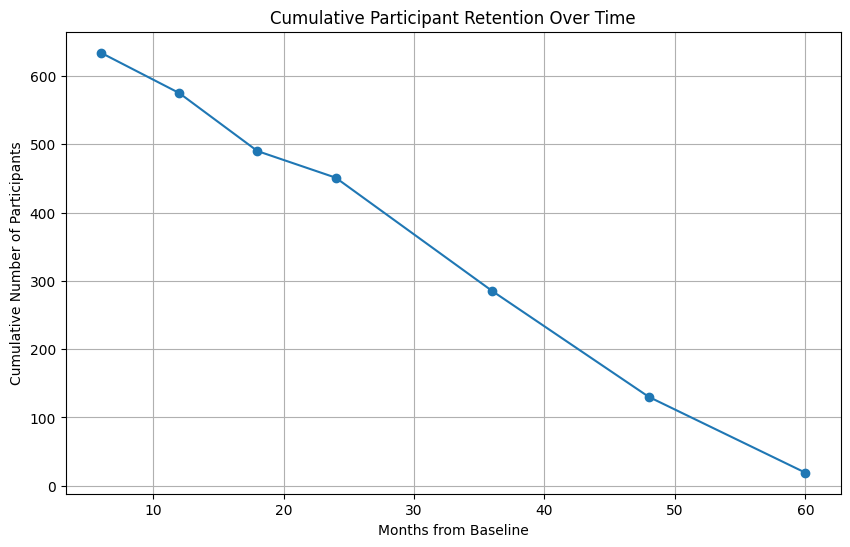

In [8]:
cumulative_counts = []
unique_rids = set()
viscode_months = sorted(merged_df["Month"].dropna().unique(), reverse=True)

for month in viscode_months:
    unique_rids.update(
        merged_df[merged_df["Month"] >= month]["RID"].unique())
    cumulative_counts.append(len(unique_rids))

viscode_months.reverse()
cumulative_counts.reverse()

plt.figure(figsize=(10, 6))
plt.plot(viscode_months, cumulative_counts, marker='o', linestyle='-')
plt.xlabel("Months from Baseline")
plt.ylabel("Cumulative Number of Participants")
plt.title("Cumulative Participant Retention Over Time")
plt.grid(True)
plt.show()

In [9]:
visit_codes = ['bl', 'm06', 'm12', 'm18', 'm24', 'm36', 'm48', 'm60']

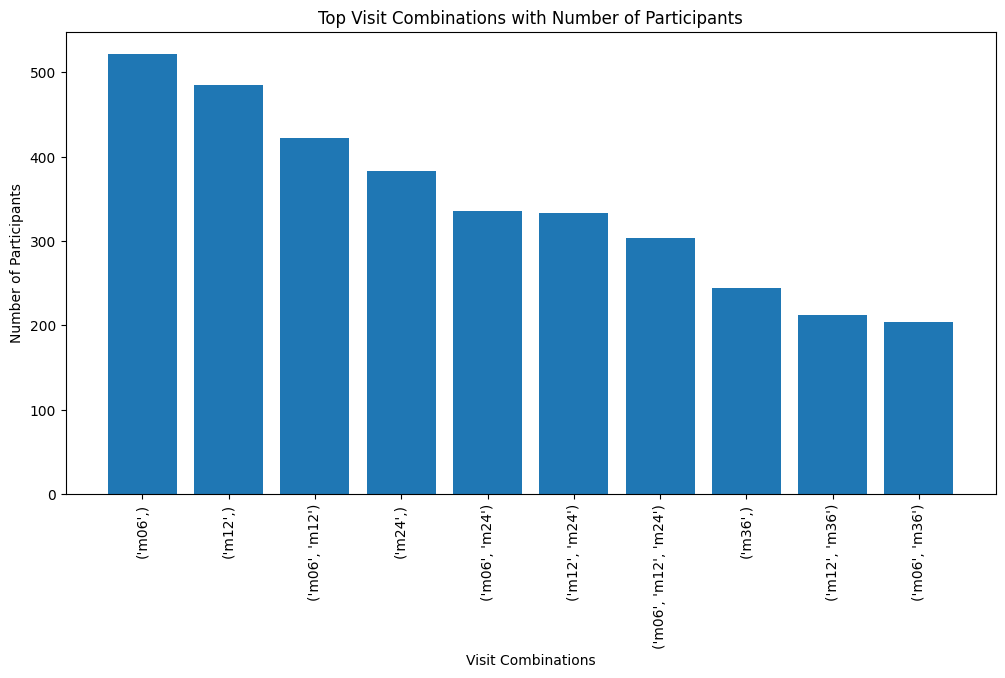

In [10]:
visit_combinations = {}
visit_dx_counts = {}
for r in range(1, len(visit_codes) + 1):
    for comb in combinations(visit_codes, r):
        selected_rids = set(merged_df[merged_df['VISCODE2'] == comb[0]]['RID'])
        for visit in comb[1:]:
            selected_rids &= set(
                merged_df[merged_df['VISCODE2'] == visit]['RID'])
        visit_combinations[comb] = len(selected_rids)

        subset_df = merged_df[merged_df['RID'].isin(selected_rids)]
        dx_count = subset_df.groupby(["DX_bl", "DX"])[
            'RID'].nunique().reset_index()
        dx_count.columns = ["DX_bl", "DX", "Num_Participants"]
        visit_dx_counts[comb] = dx_count

comb_df = pd.DataFrame([(k, v) for k, v in visit_combinations.items()], columns=[
                       'Visit_Combination', 'Num_Participants'])

comb_df_sorted = comb_df.sort_values(
    by='Num_Participants', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(comb_df_sorted)), comb_df_sorted['Num_Participants'], tick_label=[
        str(c) for c in comb_df_sorted['Visit_Combination']])
plt.xticks(rotation=90)
plt.xlabel("Visit Combinations")
plt.ylabel("Number of Participants")
plt.title("Top Visit Combinations with Number of Participants")
plt.show()

In [11]:
for comb in comb_df_sorted['Visit_Combination']:
    print(f"\nDX_bl and DX counts for visit combination {comb}:")
    print(visit_dx_counts[comb])


DX_bl and DX counts for visit combination ('m06',):
  DX_bl   DX  Num_Participants
0    AD   AD               104
1    AD  MCI                 2
2    CN   AD                 2
3    CN   CN               163
4    CN  MCI                14
5  LMCI   AD                94
6  LMCI   CN                11
7  LMCI  MCI               240

DX_bl and DX counts for visit combination ('m12',):
  DX_bl   DX  Num_Participants
0    AD   AD                86
1    AD  MCI                 2
2    CN   AD                 2
3    CN   CN               156
4    CN  MCI                15
5  LMCI   AD                97
6  LMCI   CN                 9
7  LMCI  MCI               225

DX_bl and DX counts for visit combination ('m06', 'm12'):
  DX_bl   DX  Num_Participants
0    AD   AD                77
1    AD  MCI                 2
2    CN   AD                 2
3    CN   CN               141
4    CN  MCI                14
5  LMCI   AD                83
6  LMCI   CN                 9
7  LMCI  MCI               19

In [12]:
psychom =pd.read_csv("Files/UWNPSYCHSUM_13Feb2025.csv")

In [13]:
psychom["VISCODE2"] = psychom["VISCODE2"].astype(str).str.lower()

In [14]:
psychom = psychom[['RID', 'VISCODE2', 'ADNI_MEM','ADNI_EF','ADNI_LAN','ADNI_VS', 'ADNI_EF2']]

In [15]:
merged_df = pd.merge(merged_df, psychom, left_on=[
                     "RID", "VISCODE2"], right_on=["RID", "VISCODE2"], how="left")

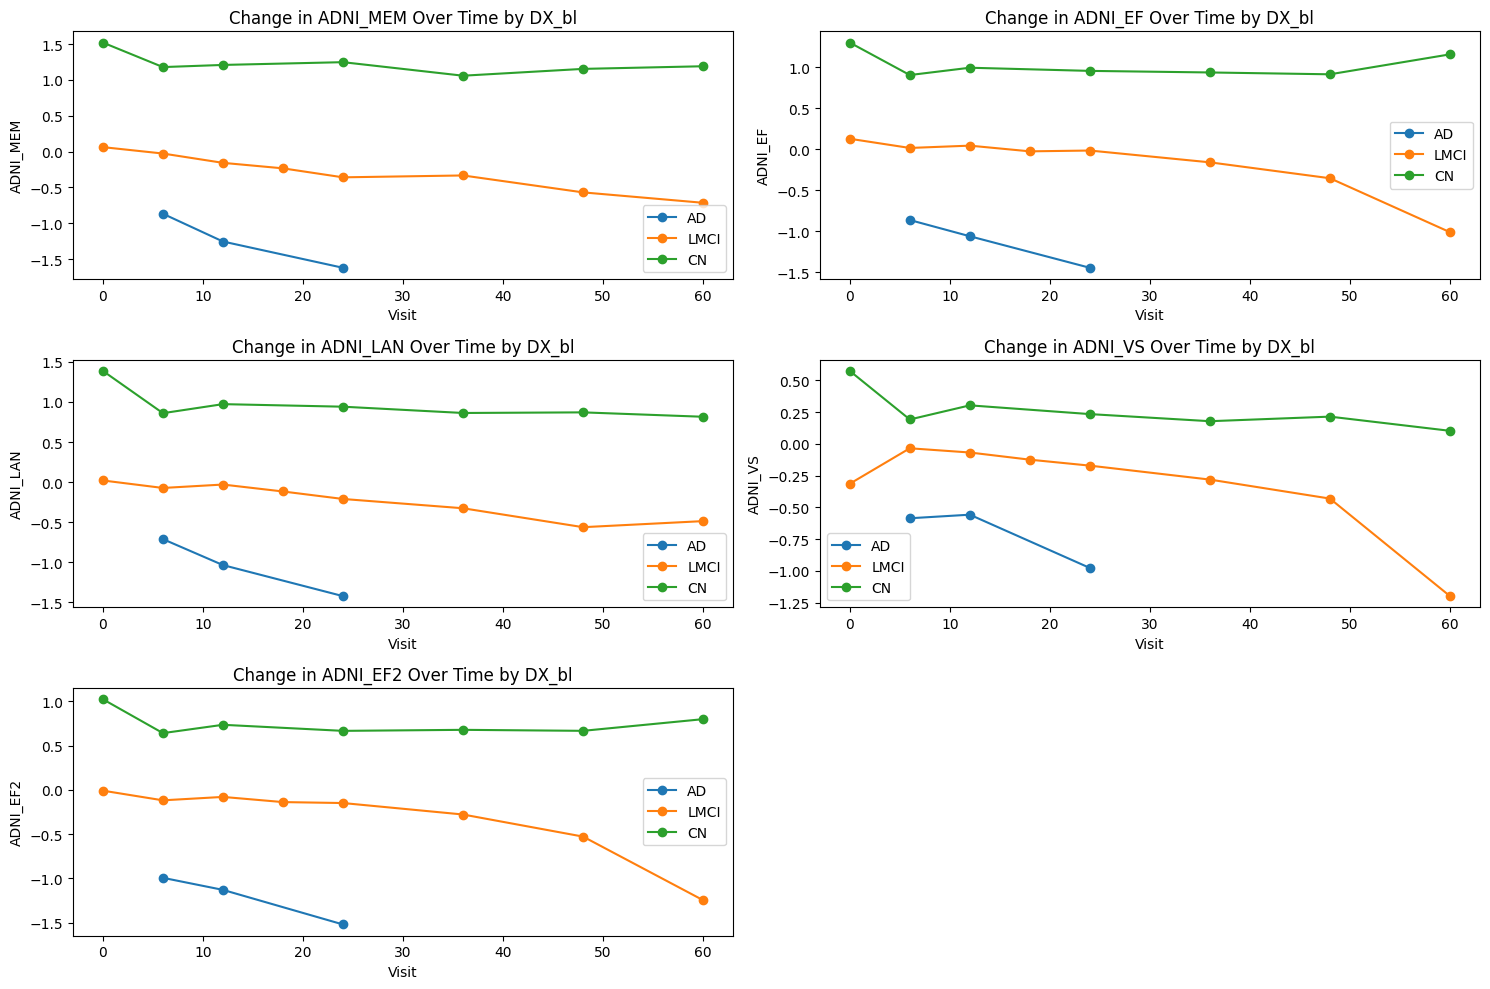

In [16]:
target_scores = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
plt.figure(figsize=(15, 10))
for i, score in enumerate(target_scores, 1):
    plt.subplot(3, 2, i)
    for dx in merged_df['DX_bl'].unique():
        subset = merged_df[merged_df['DX_bl'] == dx].groupby('M')[
            score].mean()
        plt.plot(subset.index, subset.values, marker='o', label=dx)
    plt.xlabel("Visit")
    plt.ylabel(score)
    plt.title(f"Change in {score} Over Time by DX_bl")
    plt.legend()
plt.tight_layout()
plt.show()

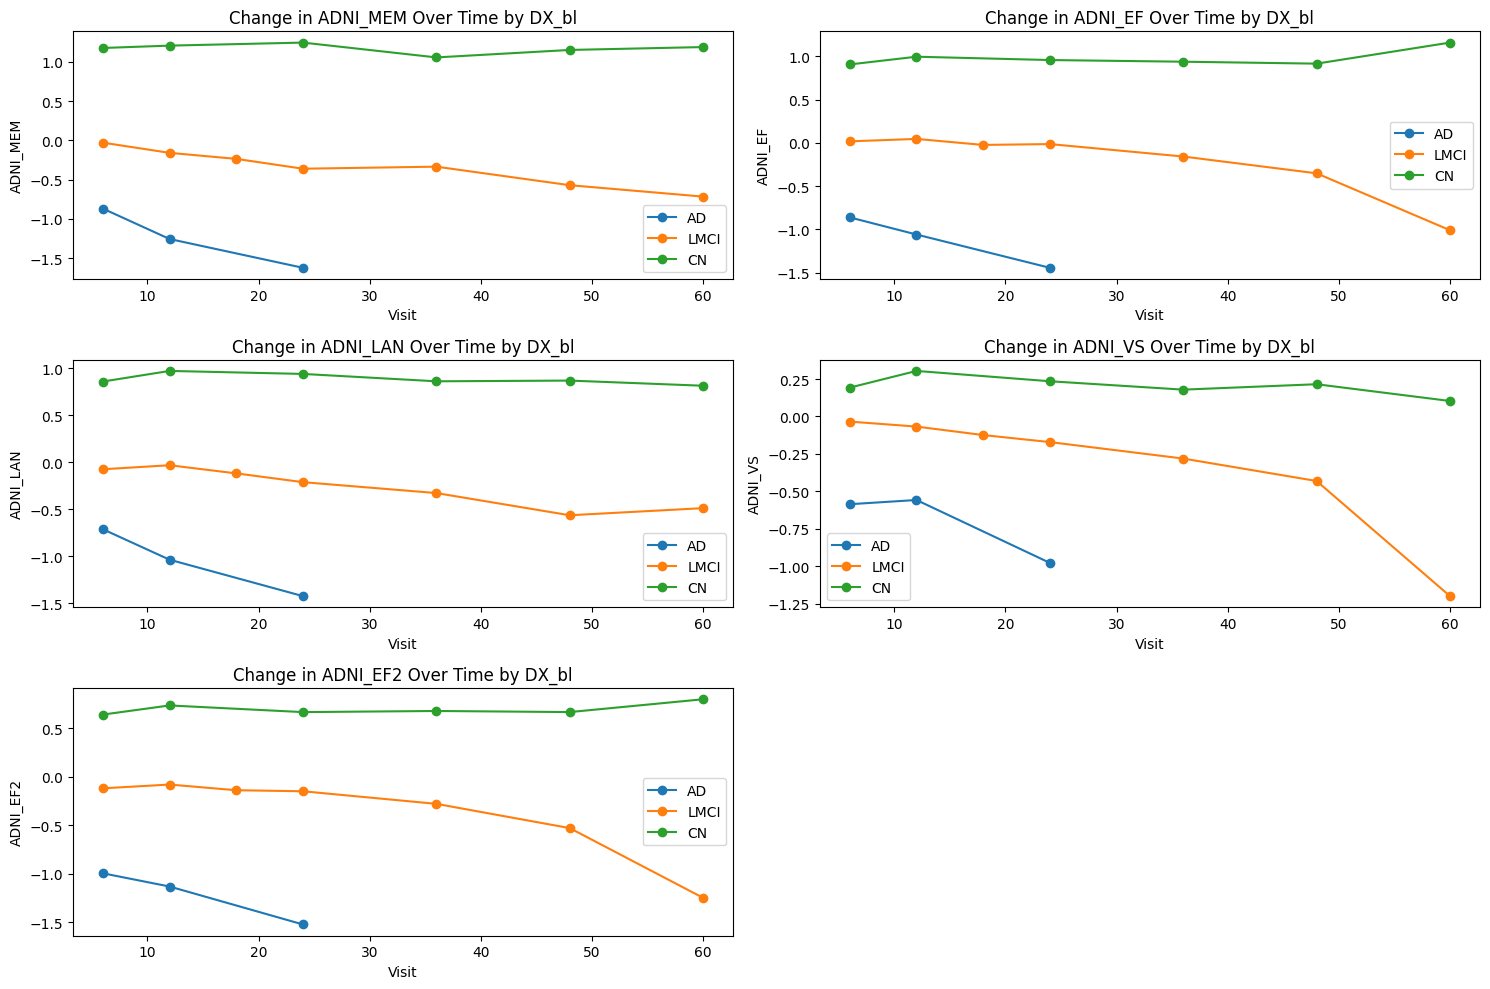

In [17]:
target_scores = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
plt.figure(figsize=(15, 10))
for i, score in enumerate(target_scores, 1):
    plt.subplot(3, 2, i)
    for dx in merged_df['DX_bl'].unique():
        subset = merged_df[merged_df['DX_bl'] == dx].groupby('Month')[
            score].mean()
        plt.plot(subset.index, subset.values, marker='o', label=dx)
    plt.xlabel("Visit")
    plt.ylabel(score)
    plt.title(f"Change in {score} Over Time by DX_bl")
    plt.legend()
plt.tight_layout()
plt.show()

In [18]:
alluvial_data = merged_df[['RID', 'DX_bl', 'DX']]

flows = alluvial_data.groupby(['DX_bl', 'DX']).size().reset_index(name='count')

color_map = {
    'CN': 'green',
    'AD': 'red',
    'LMCI': 'black'
}

flows['color'] = flows['DX_bl'].map(color_map)

fig = px.parallel_categories(
    flows,
    dimensions=['DX_bl', 'count', 'DX'],
    color='color',
    labels={'DX_bl': 'Baseline Diagnosis',
            'DX': 'Follow-up Diagnosis', 'count': 'Number of Participants'}
)

fig.update_layout(
    title="Alluvial Plot of Diagnostic Transitions", font_size=12)
fig.show()

In [19]:
alluvial_data = merged_df[['RID', 'DX_bl', 'DX']].drop_duplicates()

flows = alluvial_data.groupby(['DX_bl', 'DX'])[
    'RID'].nunique().reset_index(name='count')

color_map = {
    'CN': 'green',
    'AD': 'red',
    'LMCI': 'black'
}

flows['color'] = flows['DX_bl'].map(color_map)

fig = px.parallel_categories(
    flows,
    dimensions=['DX_bl', 'count', 'DX'],
    color='color',  
    labels={'DX_bl': 'Baseline Diagnosis',
            'DX': 'Follow-up Diagnosis', 'count': 'Number of Participants'}
)

fig.update_layout(
    title="Alluvial Plot of Diagnostic Transitions (Unique Participants)",
    font_size=12
)

fig.show()

In [20]:
selected_viscodes = ['m06', 'm12', 'm24']
valid_rids = merged_df[merged_df['VISCODE2'].isin(
    selected_viscodes)].groupby('RID')['VISCODE2'].nunique()
valid_rids = valid_rids[valid_rids == len(selected_viscodes)].index

alluvial_data = merged_df[(merged_df['VISCODE2'].isin(
    selected_viscodes)) & (merged_df['RID'].isin(valid_rids))]

alluvial_data = alluvial_data[[
    'RID', 'DX_bl', 'VISCODE2', 'DX']].drop_duplicates()

flows = alluvial_data.groupby(['DX_bl', 'VISCODE2', 'DX'])[
    'RID'].nunique().reset_index(name='count')

color_map = {
    'CN': 'green',
    'AD': 'red',
    'LMCI': 'blue'
}

flows['color'] = flows['DX_bl'].map(color_map)

flows['VISCODE2'] = flows.apply(
    lambda row: f"{row['VISCODE2']} ({row['count']})", axis=1)

fig = px.parallel_categories(
    flows,
    dimensions=['DX_bl', 'VISCODE2', 'DX'],
    color='color',  
    labels={'DX_bl': 'Baseline Diagnosis',
            'VISCODE2': 'Follow-up Timepoint',
            'DX': 'Follow-up Diagnosis'},
)

fig.update_layout(
    title="Alluvial Plot of Diagnostic Transitions (Participants with 6,12 and 24 months follow up)",
    font_size=15,
    width=1200,  
    height=800   
)

fig.show()

In [21]:
alluvial_data['RID'].nunique()

304

In [22]:
selected_viscodes = ['m06', 'm12', 'm24']
valid_rids = merged_df[merged_df['VISCODE2'].isin(
    selected_viscodes)].groupby('RID')['VISCODE2'].nunique()
valid_rids = valid_rids[valid_rids == len(selected_viscodes)].index

filtered_df = merged_df[(merged_df['VISCODE2'].isin(
    selected_viscodes)) & (merged_df['RID'].isin(valid_rids))]

changed_df = filtered_df[filtered_df['DX_bl'] != filtered_df['DX']]

multiple_changes = changed_df.groupby(
    'RID').filter(lambda x: x['DX'].nunique() > 1)

multiple_changes_rids = multiple_changes['RID'].unique()
print("RIDs with multiple changes in DX:", multiple_changes_rids)

multiple_changes.sort_values(by=['RID', 'VISCODE2'])

RIDs with multiple changes in DX: [ 873  293  294  887  906  325  839  835  204 1010 1007  214 1057 1054
  187  952  941  249  978  443  429  507  568  649  729  725  722  752
  675  658  390  708  702  388 1247   77  112 1240  108 1217 1213 1282
 1427   57 1299   42   54  141 1121 1135 1066]


,RID,VISCODE2,DX_bl,DX,PTGENDER,AGE,M,PTEDUCAT,PTETHCAT,PTRACCAT,...,RightMiddleTemporal.3,FourthVentricle,Visit_Gap,Irregular_Followup,Month,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
451,42,m06,LMCI,MCI,Male,72.8,6,18,Not Hisp/Latino,White,...,0.676,1548,NaN,False,6.0,-0.100,0.365,0.446,0.739,0.326
942,42,m12,LMCI,AD,Male,72.8,12,18,Not Hisp/Latino,White,...,0.677,1441,6.241787,False,12.0,0.002,0.130,0.461,-0.080,0.120
1349,42,m24,LMCI,AD,Male,72.8,24,18,Not Hisp/Latino,White,...,0.661,1566,12.779238,False,24.0,-0.650,0.517,0.446,0.739,0.435
459,54,m06,LMCI,MCI,Female,81.0,6,20,Not Hisp/Latino,White,...,0.644,2583,NaN,False,6.0,-0.911,-0.349,-0.196,-0.080,-0.580
836,54,m12,LMCI,AD,Female,81.0,12,20,Not Hisp/Latino,White,...,0.665,2558,5.486202,False,12.0,-1.119,-0.858,-0.522,-1.792,-1.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,1299,m12,LMCI,MCI,Male,71.8,12,14,Not Hisp/Latino,White,...,0.646,2207,5.880420,False,12.0,-0.994,-1.283,-0.346,-0.080,-1.375
1219,1299,m24,LMCI,AD,Male,71.8,24,14,Not Hisp/Latino,White,...,0.666,2251,5.814717,False,24.0,-0.911,-1.424,-0.300,-0.739,-1.526
410,1427,m06,LMCI,MCI,Female,69.6,6,12,Not Hisp/Latino,White,...,0.626,2384,NaN,False,6.0,-1.445,-1.642,-1.640,-1.813,-1.788
599,1427,m12,LMCI,AD,Female,69.6,12,12,Not Hisp/Latino,White,...,0.638,2333,6.438896,False,12.0,-1.764,-1.625,-0.946,-0.656,-2.047


In [23]:
multiple_changes['RID'].nunique()

51

In [24]:
multiple_changes['DX_bl'].value_counts()

LMCI    154
Name: DX_bl, dtype: int64

In [25]:
multiple_changes['DX'].value_counts()

MCI    80
AD     68
CN      6
Name: DX, dtype: int64

In [26]:
sleep_npiq = pd.read_csv("Files/NPIQ_07Feb2025.csv")[['RID','VISCODE2','NPIK','NPIKSEV']]

In [27]:
filtered_npiq = sleep_npiq[sleep_npiq['RID'].isin(merged_df['RID'].unique())]

viscode_counts = filtered_npiq.groupby(
    "VISCODE2")['RID'].nunique().reset_index()

viscode_counts = viscode_counts.sort_values(
    by="VISCODE2", key=lambda x: x.str.extract(r'(\d+)')[0].astype(float)
)

In [28]:
viscode_counts['cumulative_count'] = viscode_counts['RID'][::-1].cumsum()

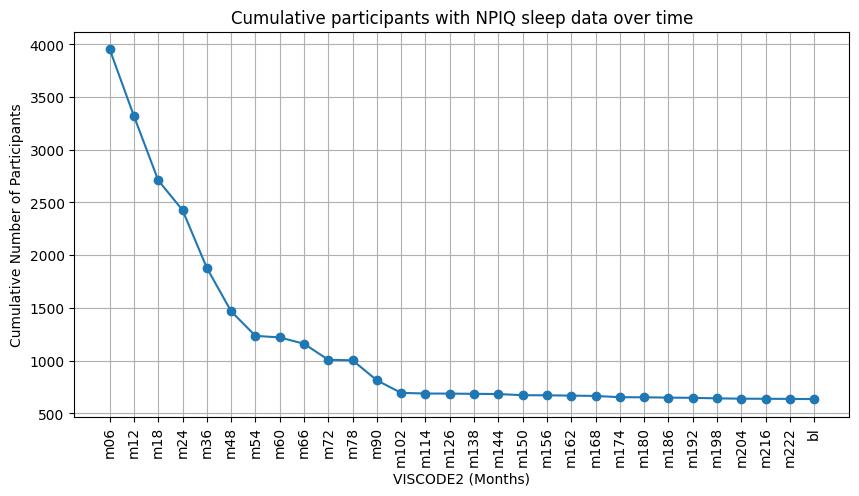

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(viscode_counts['VISCODE2'],
         viscode_counts['cumulative_count'], marker='o', linestyle='-')
plt.xlabel("VISCODE2 (Months)")
plt.ylabel("Cumulative Number of Participants")
plt.title("Cumulative participants with NPIQ sleep data over time")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [30]:
selected_viscodes = {'m06', 'm12', 'm24'}
participants_with_all_visits = merged_df.groupby('RID')['VISCODE2'].apply(set)
valid_rids = participants_with_all_visits[participants_with_all_visits.apply(
    lambda x: selected_viscodes.issubset(x))].index

In [31]:
filtered_npiq_subset = sleep_npiq[sleep_npiq['RID'].isin(valid_rids)]

In [32]:
viscode_counts_subset = filtered_npiq_subset.groupby(
    "VISCODE2")['RID'].nunique().reset_index()

In [33]:
viscode_counts_subset = viscode_counts_subset.sort_values(
    by="VISCODE2", key=lambda x: x.str.extract(r'(\d+)')[0].astype(float)
)

In [34]:
viscode_counts_subset = viscode_counts_subset.set_index('VISCODE2').reindex(['bl'] + [x for x in viscode_counts_subset['VISCODE2'] if x != 'bl']).reset_index()

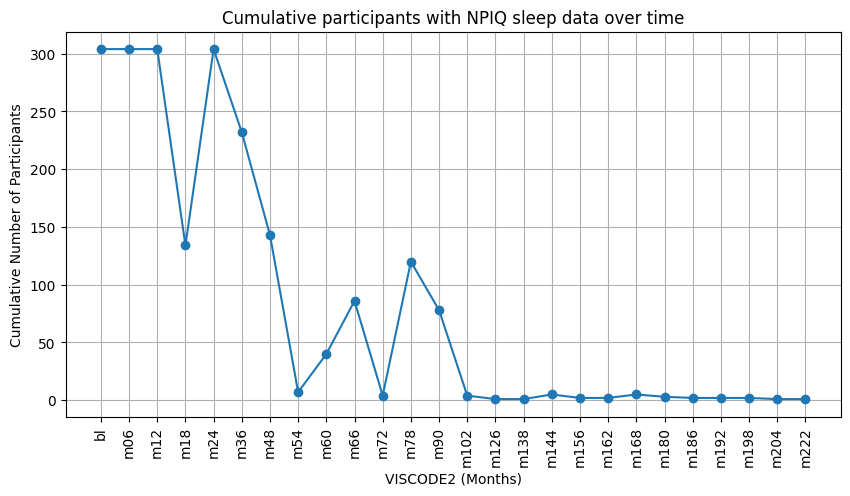

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(viscode_counts_subset['VISCODE2'],
         viscode_counts_subset['RID'], marker='o', linestyle='-')
plt.xlabel("VISCODE2 (Months)")
plt.ylabel("Cumulative Number of Participants")
plt.title("Cumulative participants with NPIQ sleep data over time")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [36]:
filtered_npiq_subset['RID'].nunique()

304

In [37]:
filtered_npiq_subset.drop_duplicates(subset=['RID']).groupby('NPIK')['RID'].nunique().reset_index(name='Participant Count')

,NPIK,Participant Count
0,0.0,270
1,1.0,33
2,2.0,1


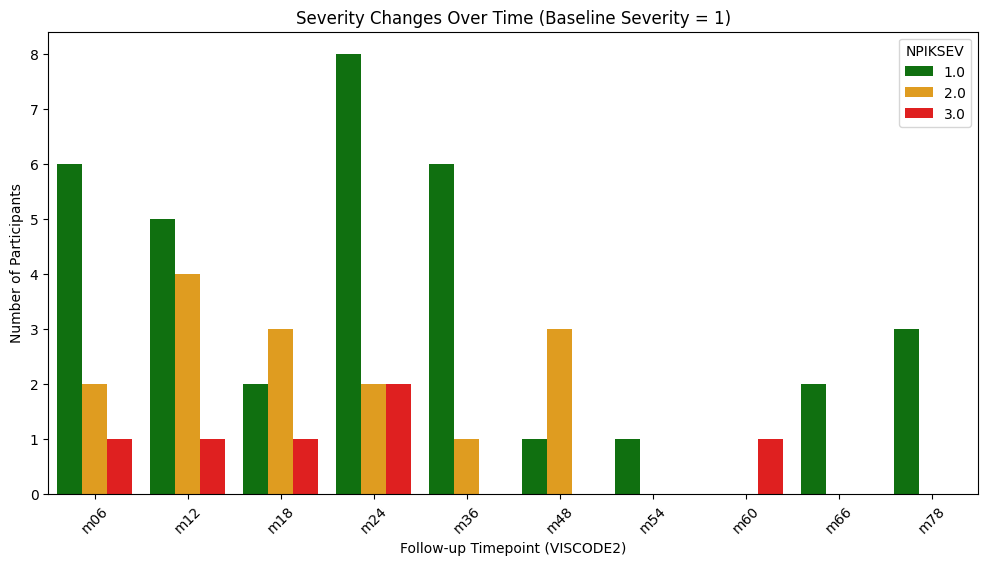

In [38]:
npik1 = filtered_npiq_subset[filtered_npiq_subset['NPIK'] == 1]

baseline_severity = npik1[npik1['VISCODE2'] == 'bl'][[
    'RID', 'NPIKSEV']].rename(columns={'NPIKSEV': 'Baseline_SEV'})

npik1 = npik1.merge(baseline_severity, on='RID', how='left')

npik1 = npik1[npik1['VISCODE2'] != 'bl']

severity_changes = npik1.groupby(['Baseline_SEV', 'VISCODE2', 'NPIKSEV'])[
    'RID'].nunique().reset_index(name='count')

plt.figure(figsize=(12, 6))

plot_data = severity_changes[severity_changes['Baseline_SEV'] == 1]

sns.barplot(data=plot_data, x='VISCODE2', y='count',
            hue='NPIKSEV', palette={1: "green", 2: "orange", 3: "red"})

plt.title(f"Severity Changes Over Time (Baseline Severity = {1})")
plt.xlabel("Follow-up Timepoint (VISCODE2)")
plt.ylabel("Number of Participants")
plt.xticks(rotation=45)
plt.show()

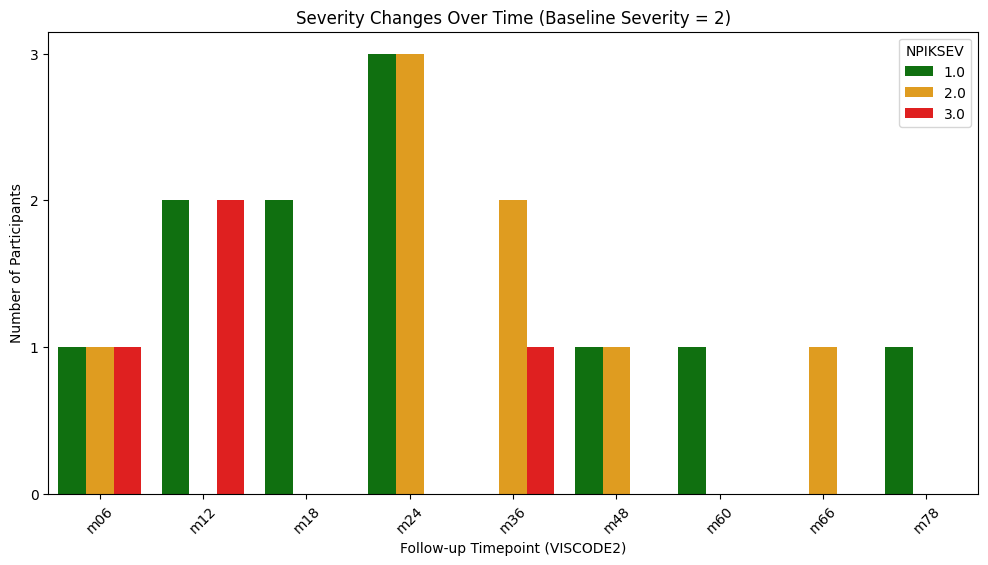

In [39]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 6))

plot_data = severity_changes[severity_changes['Baseline_SEV'] == 2]

sns.barplot(data=plot_data, x='VISCODE2', y='count',
            hue='NPIKSEV', palette={1: "green", 2: "orange", 3: "red"})

plt.title(f"Severity Changes Over Time (Baseline Severity = {2})")
plt.xlabel("Follow-up Timepoint (VISCODE2)")
plt.ylabel("Number of Participants")
plt.xticks(rotation=45)
plt.yscale('linear')

plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

In [40]:
insom_checklist = pd.read_csv("Files/ADSXLIST_13Feb2025.csv")[['RID','VISCODE2','AXINSOMN']]

In [41]:
filtered_insom = insom_checklist[insom_checklist['RID'].isin(filtered_npiq_subset['RID'].unique())]
filtered_insom['RID'].nunique()

304

In [42]:
selected_viscodes = ["m06", "m12", "m24"]
filtered_insom = filtered_insom[filtered_insom["VISCODE2"].isin(selected_viscodes)]

In [43]:
filtered_insom[(filtered_insom['VISCODE2']=='m06') & (filtered_insom['AXINSOMN']==1)]['RID'].nunique()

264

In [44]:
filtered_insom[(filtered_insom['VISCODE2'] == 'm06') & (filtered_insom['AXINSOMN'] ==2)]['RID'].nunique()

40

In [45]:
filtered_insom[filtered_insom['RID'].isin(filtered_insom[(filtered_insom['VISCODE2'] == 'm06') & (filtered_insom['AXINSOMN'] ==1)]['RID'].unique())]

,RID,VISCODE2,AXINSOMN
1,5,m06,1
6,16,m06,1
7,31,m06,1
9,22,m06,1
10,21,m06,1
...,...,...,...
3504,1269,m24,1
3516,1265,m24,1
3517,839,m24,1
3518,941,m24,1


In [46]:
filtered_insom[filtered_insom['RID'].isin(filtered_insom[(filtered_insom['VISCODE2'] == 'm06') & (filtered_insom['AXINSOMN'] == 2)]['RID'].unique())]

,RID,VISCODE2,AXINSOMN
20,40,m06,2
55,171,m06,2
56,72,m06,2
70,106,m06,2
71,108,m06,2
...,...,...,...
3078,1351,m24,1
3085,1341,m24,2
3174,1186,m24,2
3513,934,m24,2


In [47]:
pd.merge(merged_df[merged_df['RID'].isin(valid_rids)], filtered_npiq, on=['RID', 'VISCODE2'], how='inner')['RID'].nunique()

304